In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



## Define CaOH Hamiltonian and molecular states

In [3]:
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

## Define experimental parameters

In [7]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -72; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

# r1 = 3.7
# r3 = 2.8 
# r2 = 3.5

r1 = 1
r3 = 0
r2 = 1

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =1.2)
;

In [5]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_2freq_pp1000_1to1.jl";

In [9]:
using Serialization
results_list = deserialize(saving_path);

In [8]:
aom2_freqs = 50.5:0.25:55.5
# r4s = [1.08, 1.13, 1.21, 1.25, 1.31, 1.36, 1.41, 1.48, 1.52, 1.56, 1.61, 1.65, 1.69, 1.7, 1.72, 1.75, 1.75, 1.75, 1.72, 1.72, 1.72]./1.11;

50.5:0.25:55.5

In [9]:

results_list = []

for i_scan in 1:length(aom2_freqs)
    aom2_freq = aom2_freqs[i_scan]
    @printf("AOM 2: %.2f MHz \n", aom2_freq)
    Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
    blue_MOT_params.Δ2 = Δ2
    
    
    ~,diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
    blue_MOT_params.diffusion_constant = diffusion_constant
    @printf("Diffusion const = %.3f \n", diffusion_constant)
    
    sequence = [blue_MOT_params]
    durations = [15e-3]
    generate_sequence!(sequence, durations);
    results = simulate_particles_constant_diffusion(package, package_A, sequence)
    push!(results_list, results)
    
    serialize(saving_path, results_list)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
    
end

AOM 2: 50.50 MHz 


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


Diffusion const = 0.213 


Progress: 100%|█████████████████████████████████████████| Time: 0:18:29                                                                          


Survival: 37 / 1000
goodness = 0.00

AOM 2: 50.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
Progress:   1%|█                                        |  ETA: 0:18:49

Diffusion const = 0.216 


Progress: 100%|█████████████████████████████████████████| Time: 0:18:49


Survival: 55 / 1000
goodness = 0.00

AOM 2: 51.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


Diffusion const = 0.219 


Progress: 100%|█████████████████████████████████████████| Time: 0:22:02                                                                           


Survival: 70 / 1000
goodness = 0.01

AOM 2: 51.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


Diffusion const = 0.223 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:56


Survival: 85 / 1000
goodness = 0.01

AOM 2: 51.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.223 


Progress: 100%|█████████████████████████████████████████| Time: 0:22:06                                                                        


Survival: 102 / 1000
goodness = 0.01

AOM 2: 51.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23
Progress:   3%|██                                       |  ETA: 0:20:42

Diffusion const = 0.229 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:53


Survival: 123 / 1000
goodness = 0.02

AOM 2: 52.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.229 


Progress: 100%|█████████████████████████████████████████| Time: 0:19:11


Survival: 136 / 1000
goodness = 0.02

AOM 2: 52.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


Diffusion const = 0.230 


Progress: 100%|█████████████████████████████████████████| Time: 0:18:59


Survival: 136 / 1000
goodness = 0.02

AOM 2: 52.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


Diffusion const = 0.231 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:29


Survival: 160 / 1000
goodness = 0.02

AOM 2: 52.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.231 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:08


Survival: 170 / 1000
goodness = 0.03

AOM 2: 53.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
Progress:   3%|██                                       |  ETA: 0:22:48

Diffusion const = 0.232 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:33


Survival: 171 / 1000
goodness = 0.03

AOM 2: 53.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


Diffusion const = 0.228 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:23


Survival: 174 / 1000
goodness = 0.02

AOM 2: 53.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.225 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:25


Survival: 150 / 1000
goodness = 0.02

AOM 2: 53.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
Progress:   1%|█                                        |  ETA: 0:31:23

Diffusion const = 0.223 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:44


Survival: 185 / 1000
goodness = 0.02

AOM 2: 54.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.223 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:42


Survival: 178 / 1000
goodness = 0.02

AOM 2: 54.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


Diffusion const = 0.220 


Progress: 100%|█████████████████████████████████████████| Time: 0:19:27


Survival: 154 / 1000
goodness = 0.02

AOM 2: 54.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


Diffusion const = 0.217 


Progress: 100%|█████████████████████████████████████████| Time: 0:19:28


Survival: 125 / 1000
goodness = 0.01

AOM 2: 54.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
Progress:   0%|█                                        |  ETA: 0:54:44

Diffusion const = 0.220 


Progress: 100%|█████████████████████████████████████████| Time: 0:18:29


Survival: 81 / 1000
goodness = 0.01

AOM 2: 55.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


Diffusion const = 0.216 


Progress: 100%|█████████████████████████████████████████| Time: 0:15:28


Survival: 49 / 1000
goodness = 0.00

AOM 2: 55.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.217 


Progress: 100%|█████████████████████████████████████████| Time: 0:14:31


Survival: 26 / 1000
goodness = 0.00

AOM 2: 55.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


Diffusion const = 0.221 


Progress: 100%|█████████████████████████████████████████| Time: 0:12:38


Survival: 11 / 1000
goodness = 0.00



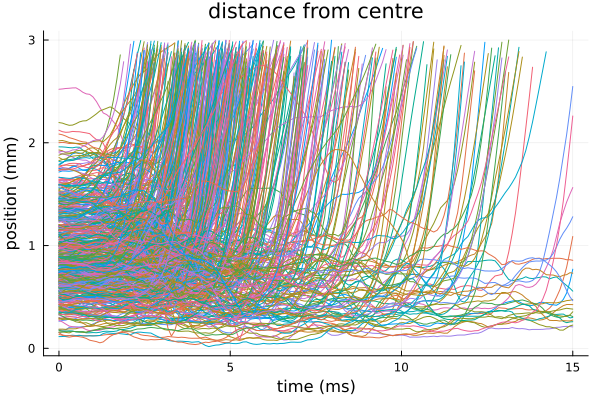

In [42]:
plot_all_trajectories(results_list[end],"all")
plot!()

0.06884327744098999
0.1344048122769839


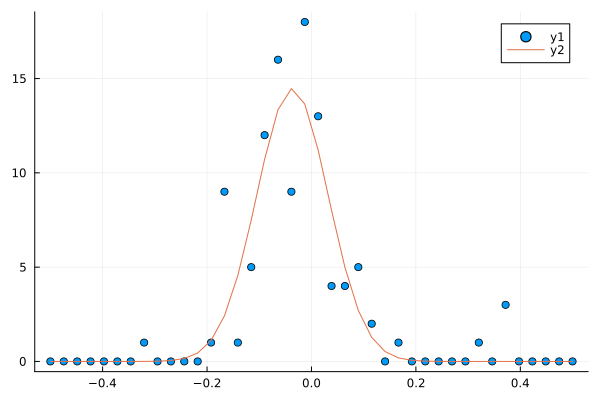

In [54]:
n_values = 500
results = results_list[end-4]
t_end = 15

sizes = []
x_grid = collect(LinRange(-0.5, 0.5, 40))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived_t(results1, t_end)

xs = [results1.z_trajectories[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

println(fit.param[2])
println(plot_size(results1, "x")[2][end])
#     println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

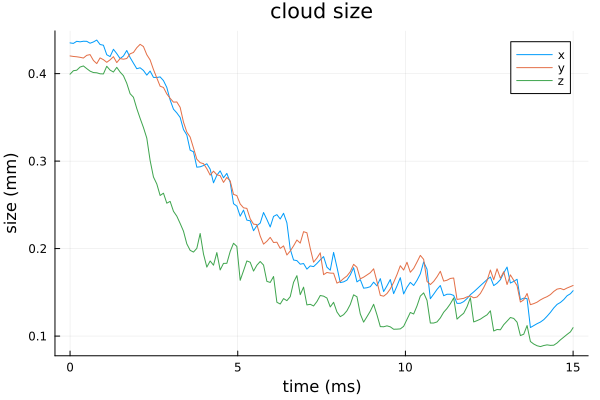

In [76]:
plot_size(results_list[end],"all")
plot!()

In [28]:
sizes = []
size_errors = []
for results in results_list[3:end-3]
    size, error = bootstrap_size_fit(results, 14; iter=100, range=0.5, n_grids=15)
    println(size)
    push!(sizes, size)
    push!(size_errors, error)
end

signals = []
signal_errors = []

for results in results_list[3:end-3]
    signal, error = bootstrap_survival(results,15, iter=100,rmax=5.0)
    push!(signals, signal)
    push!(signal_errors, error)
end

0.13393947887915858
0.17933061155584845
0.1580492393232659
0.1355974515580794
0.14634202463573825
0.12769582085976453
0.14888296546077678
0.1302423053613084
0.13832170188665965
0.1322598213530512
0.13529531771357986
0.1398469978752883
0.13881510160752158
0.15589968520593037
0.16273145006900605
0.14590848083792077


149.33306764497544
124.72668372304362
160.78516247949784
190.15563572811135
138.7489134292374
159.79794955453085
174.92226374940088
192.27818549558694
196.87636148801164
179.13275029228805
281.5945669384518
243.84254481688404
287.151630412646
236.14719646661445
280.90358517625236
291.090835685601


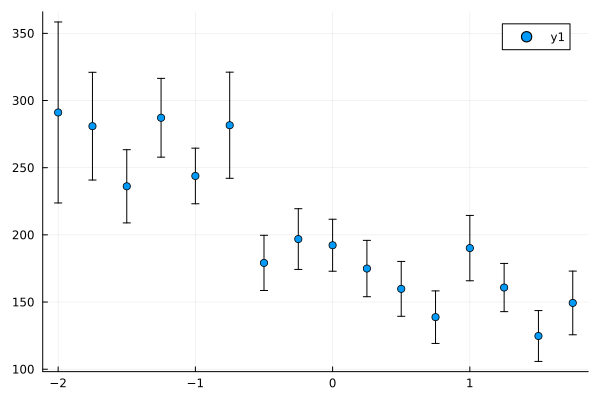

In [20]:

temps = Float64[]
temp_errors = Float64[]
for results in results_list[3:end-3]
    temp, error = bootstrap_temperature_fit(results, 10; iter=100, rmax=1.0)
    println(temp)
    push!(temps, temp)
    push!(temp_errors, error)
end

scatter(52.75.- aom2_freqs[3:end-3],temps, yerr=temp_errors)

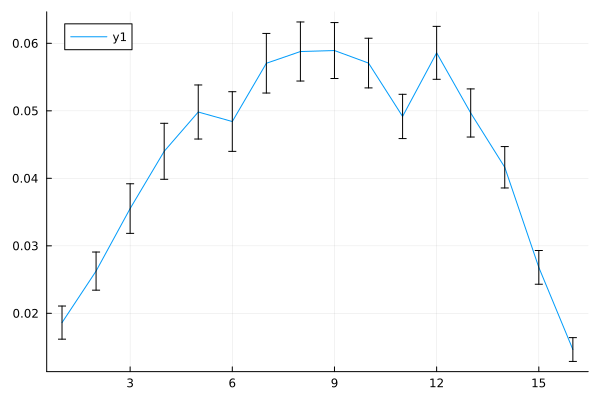

In [21]:
plot(signals, yerr=signal_errors)

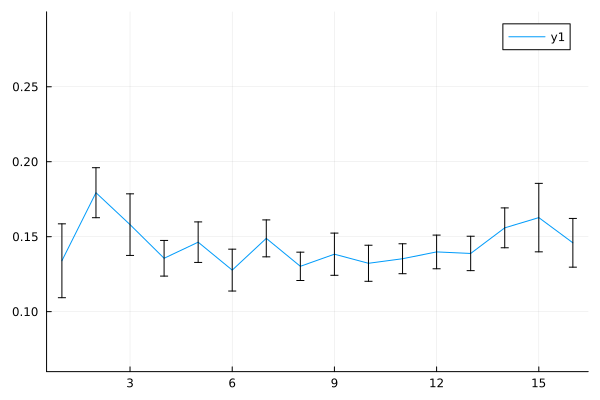

In [29]:
plot(sizes, yerr=size_errors, ylim=[0.06,0.3])

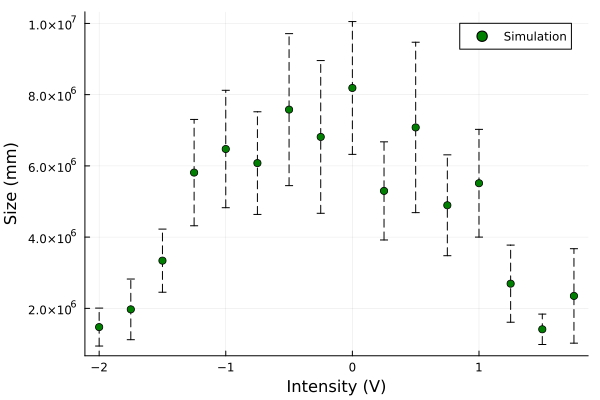

In [30]:
units = 1e3 * 2900/0.6
densities = signals./sizes.^3 * units / (2π)^(3/2)
density_errors = sqrt.((signal_errors ./ sizes.^3).^2 + (3 .* size_errors .* signals ./sizes.^4).^2) * units / (2π)^(3/2)

scatter(52.75 .- aom2_freqs[3:end-3],densities, yerr=density_errors ,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

plot!()

## Find the diffusion constant

In [16]:
diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-3, n_particles=100, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  41%|█████████████████                        |  ETA: 0:08:56┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  42%|██████████████████                       |  ETA: 0:09:14┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  62%|██████████████████████████               |  ETA: 0:05:40┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  63%|██████████████████████████               |  ETA: 0:05:30┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|██████████████████████████

Diffusion constant = 1.78 


In [22]:
diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=8e-4, n_particles=100, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=150e-6)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress:  21%|█████████                                |  ETA: 0:09:58┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:12:09


Diffusion constant = 1.56 


In [31]:
using MAT

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\2freq_pp_simulations.mat";

In [22]:
close(file)

In [32]:
file = matopen(simulation_file_path, "w")
write(file, "aom1_freqs", collect(aom2_freqs[3:end-3]))

write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_densities", densities)
write(file, "simulation_density_errors_3", density_errors)

close(file);

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

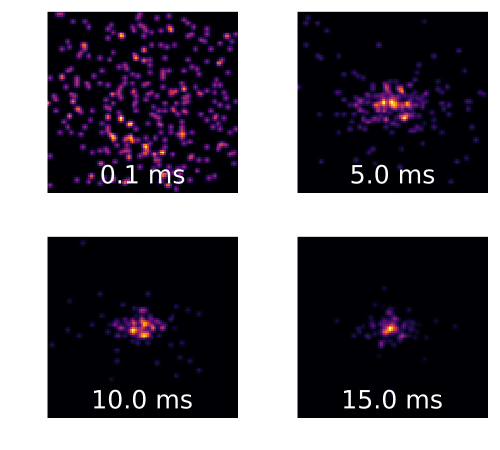

In [47]:
results= results_list[end-4]
ROI = 0.8  # mm

img_duration = 0.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,5,10,15]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()

In [34]:
results = results_list[6]

ts = 0.1:0.5:15
sizes = Float64[]
errors = Float64[]
signals = Float64[]

for t in ts
    size, error = bootstrap_size_fit(results, t; iter=100, range=1.0, n_grids=20)
    push!(sizes, size)
    push!(errors, error)
    signal, error = bootstrap_survival(results,t; iter=100, rmax=5.0)
    push!(signals, signal)
end

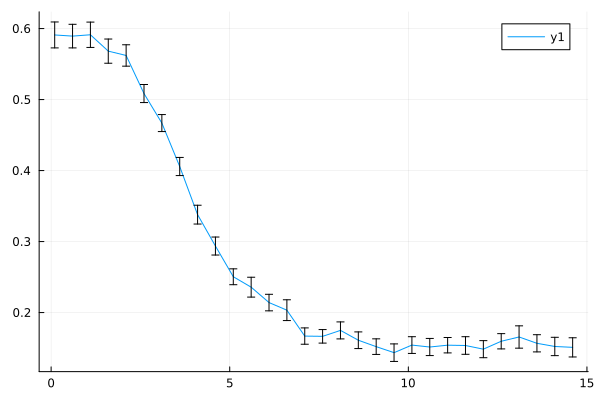

In [35]:
plot(ts, sizes,yerr=errors)

In [44]:
plot(ts, signals)

In [45]:
bootstrap_temperature_fit(results,15;iter=100)

(193.0805304312179, 25.033830852736987)